In [1]:
import argparse 
import os
import warnings
import numpy as np
#from utils.functions import model_select
from data.GenerateData_fun import DataSet
import torch
import yaml
from utils.utils import set_seed
import torch.utils.data as tud
from torch.utils.data import TensorDataset
from model.net import net_select
from model.test_fun import Gaussian

In [2]:
from utils.getconfig import getcfg
warnings.filterwarnings("ignore")
parser = argparse.ArgumentParser('Training of the Architectures', add_help=True)
parser.add_argument('-c','--config_file', type=str, 
                            help='Path to the configuration file',
                            default='/home/ubuntu/myproject/wcr_neural/config/config_1D.yaml')
args=parser.parse_args(args=[])
config_file = args.config_file

In [3]:
torch.set_float32_matmul_precision("medium")
with open(config_file, 'r') as stream:
    config = yaml.load(stream, yaml.FullLoader)
cfg_train = config['train']
cfg_data = config['data']
cfg_nn = config['NN']
print(cfg_nn)
c_proj = config['Project']
device = config['device']
set_seed(config['seed'])
# get definition of sde


{'dim': 1, 'width': 100, 'depth': 5, 'activation': 'GeLU', 'lr': 0.01, 'gamma': 0.5, 'step_size': 5, 'weight_decay': 1e-05, 'iter': 2000, 'mode': 'KAN', 'kanwidth': [1, 2, 1]}


In [4]:
def model_select(model):
    if model == 'pdcd':
        drift = lambda x: x - x ** 3
        diffusion = diffusion_constant
    return drift, diffusion

def diffusion_constant(x):
    '''
    n,1
    '''
    diag = torch.eye(x.shape[1]).to(device)
    return diag.unsqueeze(0).repeat(x.shape[0],1,1)
drift,diffusion = model_select(cfg_data['model'])

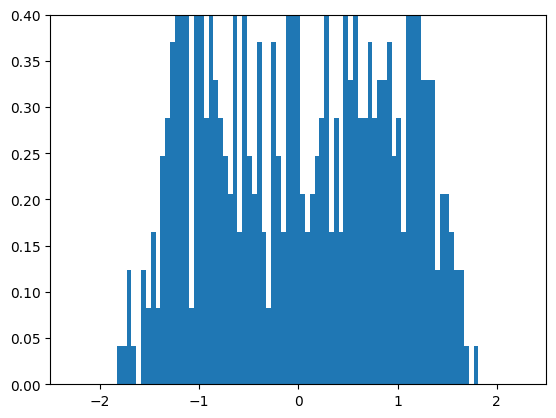

In [5]:
# generate dataset   
dt = cfg_data['dt'] # 生成数据的dt
t = torch.linspace(0,cfg_data['T'],cfg_data['nt']).to(device)# 生成数据的时间轴
dim = cfg_data['dim'] #问题维数
samples = cfg_data['sample'] #生成轨道数量
dataset = DataSet(t, dt=dt, samples_num=samples, dim=dim, drift_fun=drift, diffusion_fun=diffusion,
                    initialization=torch.normal(mean=0., std=cfg_train['sigma_init'], size=(samples, dim)),device = device)
data = dataset.get_data(plot_hist=True) # t, sample_num ,dim


In [6]:
# get NN
testFunc = Gaussian
net_drift , net_diffusion = net_select(cfg_nn,device)

In [7]:
from model.modelkan import KANModel
from model.model import Model
import torch.nn as nn
import pytorch_lightning as pl
from torch import optim
from kan import KAN, LBFGS

In [8]:
match cfg_nn['mode']:
        case 'KAN':
                model = KANModel(t = t, 
                        data = data, 
                        testFunc = testFunc, 
                        drift = drift, 
                        diffusion = diffusion, 
                        net_drift = net_drift,
                        net_diffusion = net_diffusion,  
                        cfg_train = cfg_train, 
                        cfg_nn = cfg_nn, 
                        device = data.device)
        case 'DNN':
                model = Model(t = t, 
                        data = data, 
                        testFunc = testFunc, 
                        drift = drift, 
                        diffusion = diffusion, 
                        net_drift = net_drift,
                        net_diffusion = net_diffusion,  
                        cfg_train = cfg_train, 
                        cfg_nn = cfg_nn, 
                        device = data.device)
#print(model)

'sampleTestFunc_all' took 0.023873 s



In [9]:
optimizer1 = LBFGS(model.net_drift.parameters(), lr=1, max_iter= 5, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-7, tolerance_change=1e-7, tolerance_ys=1e-7)
optimizer2 = optim.AdamW(model.net_diffusion.parameters(), lr=cfg_nn["lr"], weight_decay=cfg_nn["weight_decay"])
optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-2, tolerance_change=1e-2, tolerance_ys=1e-2)

In [10]:
from tqdm import tqdm
pbar = tqdm(range(cfg_nn['step_size']), desc='description')

description:   0%|          | 0/5 [00:00<?, ?it/s]

In [11]:
import time 
t0=time.time()

In [12]:
def closure():
    loss = torch.sum(model.compute_loss(data) ** 2)
    t1 = time.time()
    print(t1-t0)
    loss.backward()
    t1 = time.time()
    print(t1-t0)
    print(loss.detach().cpu().numpy())
    return loss

In [ ]:
xx = torch.linspace(-2,2,41).unsqueeze(1).to(device)
for _ in pbar:
    l2_drift = torch.mean((model.net_drift(xx)-drift(xx))**2).cpu().detach().numpy()
    l2_diffusion = torch.mean((model.net_diffusion(xx)-diffusion(xx))**2).cpu().detach().numpy()
    #pbar.set_description("l2_drift:{},l2_diffusion:{}".format(l2_drift,l2_diffusion))
    print("l2_drift:{},l2_diffusion:{}".format(l2_drift,l2_diffusion))
    optimizer1.step(closure)
    optimizer2.step()

In [14]:
l2_drift = torch.mean((model.net_drift(xx)-drift(xx))**2).cpu().detach().numpy()
l2_diffusion = torch.mean((model.net_diffusion(xx)-diffusion(xx))**2).cpu().detach().numpy()
#pbar.set_description("l2_drift:{},l2_diffusion:{}".format(l2_drift,l2_diffusion))
print("l2_drift:{},l2_diffusion:{}".format(l2_drift,l2_diffusion))

l2_drift:7.9160475730896,l2_diffusion:0.7100162506103516
